# Clustering Performance on Benchmark Graphs 

Comparison of ground truth of small benchmark graphs with 1M nodes and varying mixing parameter against clusterings obtained by all algorithms.
See the LFRGeneration notebook on how to obtain the graphs.

In [1]:
import numpy as np
import matplotlib as mpl
%matplotlib inline

import pandas as pd

import json
import glob
import os

In [2]:
def plot_and_save(df, name, kind='line', xlabel=None, ylabel=None, **kwargs):
    ax = df.plot(kind=kind, **kwargs)
    
    if xlabel != None:
        ax.set_xlabel(xlabel)
    if ylabel != None:
        ax.set_ylabel(ylabel)
    
    df.to_csv("../../paper/plots/" + name + ".csv")
    if 'yerr' in kwargs:
        kwargs['yerr'].to_csv("../../paper/plots/" + name + "_std_err.csv")

In [3]:
data = {}

paths = glob.glob("../../data/results/lfr_params_ground_truth/*.json") # data on ground truths and pairwise comparisons
paths += glob.glob("../../data/results/lfr_params/**/*.json", recursive=True) # data on clusterings obtained by all algos

for path in paths:
  for typename, items in json.load(open(path)).items():
      if typename in data:
        for key, object_data in items.items():
          if key in data[typename]:
            data[typename][key].update(object_data)
          else:
            data[typename][key] = object_data
      else:
        data[typename] = items

frames = { typename: pd.DataFrame.from_dict(items, orient='index') for typename, items in data.items() }

In [4]:
dlslm_label = 'DSLM-Mod'
dlslm_me_label = 'DSLM-Map'
seq_postfix = ' w. Seq.'
no_contraction_postfix = ' w/o Cont.'
dlslm_ws_label = dlslm_label + seq_postfix
dlslm_nc_label = dlslm_label + no_contraction_postfix
seq_louvain_label = 'Seq. Louvain'
seq_infomap_label = 'Seq. Infomap'
plm_label = 'PLM'
relax_map_label = 'RelaxMap'
gossip_map_label = 'GossipMap'

algo_name_mapping = {
    'synchronous local moving with map equation': dlslm_me_label,
    'synchronous local moving with modularity': dlslm_label,
    'sequential louvain': seq_louvain_label,
    'sequential infomap': seq_infomap_label,
    'relax map': relax_map_label,
    'gossip map': gossip_map_label
}

frames['algorithm_run'].replace({ 'algorithm': algo_name_mapping }, inplace=True)

frames['algorithm_run']['algorithm'] += frames['algorithm_run'].merge(frames['program_run'], left_on='program_run_id', right_index=True, how='left')['switch_to_seq'].map({ False: '', True: seq_postfix, np.NaN: '' })
frames['algorithm_run']['algorithm'] += frames['algorithm_run'].merge(frames['program_run'], left_on='program_run_id', right_index=True, how='left')['contraction'].map({ False: no_contraction_postfix, True: '', np.NaN: '' })
frames['program_run']['mu'] = pd.to_numeric(frames['program_run']['graph'].str[38]) / 10.0

In [5]:
# group comparison data by algorithm and mu
comparison_data = frames['clustering'] \
    .merge(frames['clustering_comparison'], left_index=True, right_on='compare_clustering_id') \
    .merge(frames['algorithm_run'], left_on='algorithm_run_id', right_index=True) \
    .merge(frames['program_run'], left_on='program_run_id', right_index=True) \
    .groupby(['mu', 'algorithm'])

## Comparison by NMI

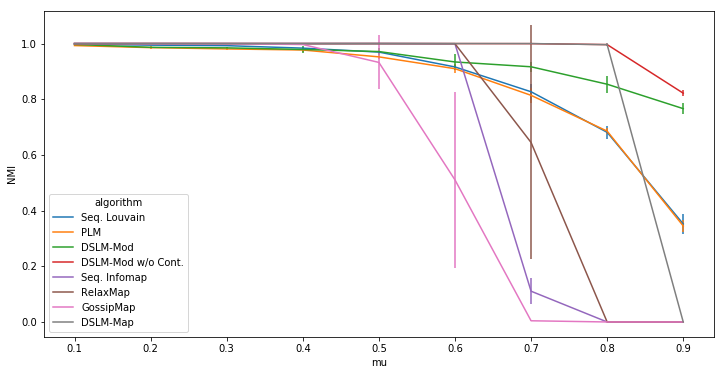

In [6]:
nmi_mean = comparison_data['NMI'].mean().to_frame().unstack() \
    ["NMI"][[seq_louvain_label, plm_label, dlslm_label, dlslm_nc_label, seq_infomap_label, relax_map_label, gossip_map_label, dlslm_me_label]]
    
nmi_err = comparison_data['NMI'].std().to_frame().unstack() \
    ["NMI"][[seq_louvain_label, plm_label, dlslm_label, dlslm_nc_label, seq_infomap_label, relax_map_label, gossip_map_label, dlslm_me_label]]

plot_and_save(nmi_mean, "quality_NMI", yerr=nmi_err, ylabel="NMI", figsize=(12, 6))

## Comparison by ARI

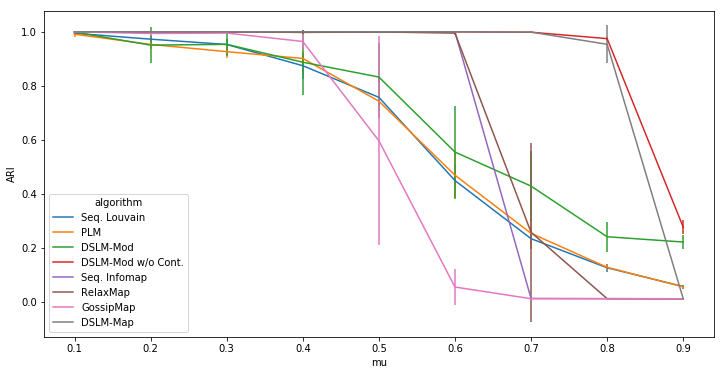

In [7]:
ari_mean = comparison_data['ARI'].mean().to_frame().unstack() \
    ["ARI"][[seq_louvain_label, plm_label, dlslm_label, dlslm_nc_label, seq_infomap_label, relax_map_label, gossip_map_label, dlslm_me_label]]
    
ari_err = comparison_data['ARI'].std().to_frame().unstack() \
    ["ARI"][[seq_louvain_label, plm_label, dlslm_label, dlslm_nc_label, seq_infomap_label, relax_map_label, gossip_map_label, dlslm_me_label]]

plot_and_save(ari_mean, "quality_ARI", yerr=ari_err, ylabel="ARI", figsize=(12, 6))

## Modularity Scores

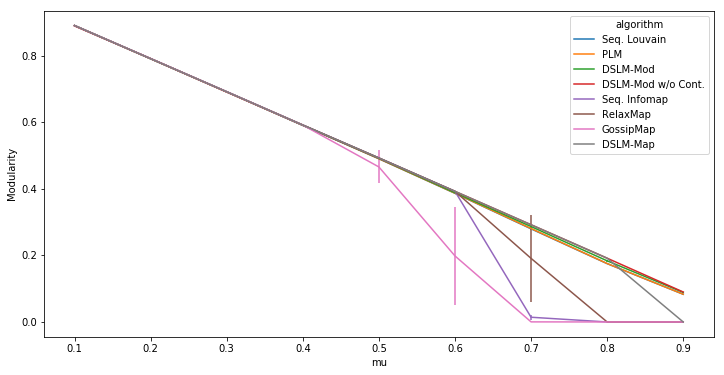

In [8]:
mod_mean = comparison_data['modularity'].mean().to_frame().unstack() \
    ["modularity"][[seq_louvain_label, plm_label, dlslm_label, dlslm_nc_label, seq_infomap_label, relax_map_label, gossip_map_label, dlslm_me_label]]
    
mod_err = comparison_data['modularity'].std().to_frame().unstack() \
    ["modularity"][[seq_louvain_label, plm_label, dlslm_label, dlslm_nc_label, seq_infomap_label, relax_map_label, gossip_map_label, dlslm_me_label]]

plot_and_save(mod_mean, "quality_modularity", yerr=mod_err, ylabel="Modularity", figsize=(12, 6))

## MapEquation Scores

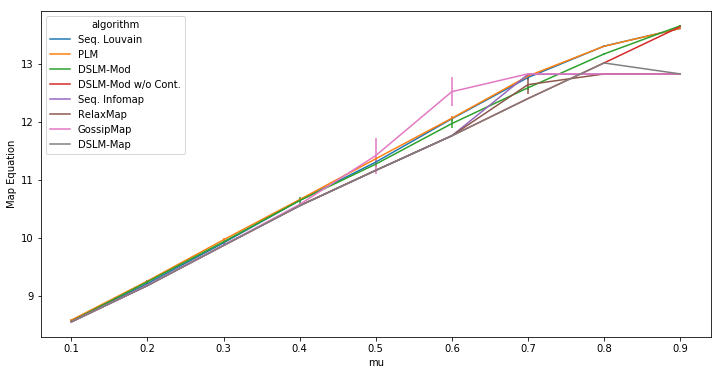

In [9]:
map_mean = comparison_data['map_equation'].mean().to_frame().unstack() \
    ["map_equation"][[seq_louvain_label, plm_label, dlslm_label, dlslm_nc_label, seq_infomap_label, relax_map_label, gossip_map_label, dlslm_me_label]]
    
map_err = comparison_data['map_equation'].std().to_frame().unstack() \
    ["map_equation"][[seq_louvain_label, plm_label, dlslm_label, dlslm_nc_label, seq_infomap_label, relax_map_label, gossip_map_label, dlslm_me_label]]

plot_and_save(map_mean, "quality_map_equation", yerr=map_err, ylabel="Map Equation", figsize=(12, 6))